In [2]:
# in your notebook or another script
from data_test import get_core_filtered
from data_enrichment import get_features

RAW_DIR = "data/raw"

# a) only filtered core DataFrames (Big-5) in memory
core = get_core_filtered(RAW_DIR)
df_teams_season       = core["df_teams_season"]
df_teams_details      = core["df_teams_details"]
df_players_profile    = core["df_players_profile"]
df_player_performance = core["df_player_performance"]

# b) features + Ballon d'Or flag in one line
df_feats, feature_cols = get_features(RAW_DIR)


/workspaces/Machine-learning/data_enrichment.py:232: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["ballon_dor_winner"] = df["ballon_dor_winner"].fillna(False).astype(bool)


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import preprocessing
import textwrap


In [4]:
df_feats

,player_id,season_name,goals,assists,penalty_goals,own_goals,yellow_cards,second_yellow_cards,direct_red_cards,minutes_played,...,matches_played_z_lag1,matches_played_z_delta,ga_per90_w,g_per90_w,a_per90_w,gc_per90_w,clean_sheet_rate_w,discipline_rate_w,pen_share_w,ballon_dor_winner
0,1000136,22/23,0.0,0,0,0,0,0,0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,False
1,1000136,23/24,0.0,0,0,0,0,0,0,0.0,...,-1.225316,0.000527,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,False
2,1000136,24/25,0.0,0,0,0,0,0,0,0.0,...,-1.224789,0.083476,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,False
3,1000626,24/25,0.0,0,0,0,0,0,0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,False
4,1000630,25/26,0.0,0,0,0,0,0,0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31072,99923,07/08,0.0,0,0,0,0,0,0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,-0.133333,0.0,False
31073,99923,10/11,0.0,0,0,0,0,0,0,0.0,...,-0.597849,-0.166462,0.0,0.0,0.0,0.0,0.0,-0.133333,0.0,False
31074,99923,14/15,0.0,1,0,0,2,0,0,0.0,...,-0.764312,0.065543,0.0,0.0,0.0,0.0,0.0,0.266667,0.0,False
31075,999402,23/24,0.0,0,0,0,0,0,0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,False


correlation analysis 

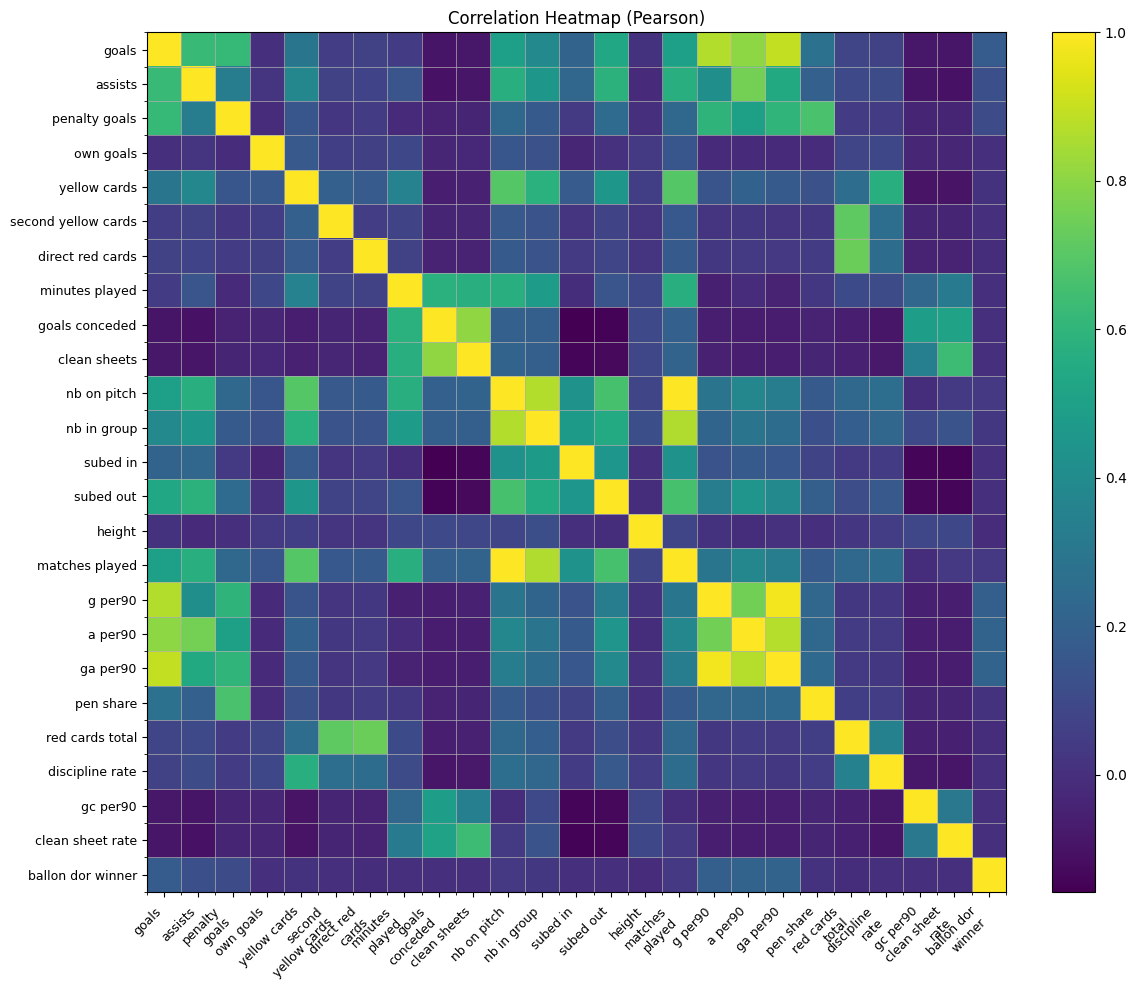

In [7]:
safe_cols = [
    "goals","assists","penalty_goals","own_goals","yellow_cards","second_yellow_cards",
    "direct_red_cards","minutes_played","goals_conceded","clean_sheets","nb_on_pitch",
    "nb_in_group","subed_in","subed_out","height","matches_played","g_per90","a_per90",
    "ga_per90","pen_share","red_cards_total","discipline_rate","gc_per90","clean_sheet_rate",
    "ballon_dor_winner",
]

X = df_feats[safe_cols].replace([np.inf, -np.inf], np.nan).dropna()
corr = X.corr(method="pearson")

# wrap labels to multiple lines (split underscores + wrap to width)
def wrap_label(s, width=12):
    s = s.replace("_", " ")
    return "\n".join(textwrap.wrap(s, width=width))

xlabels = [wrap_label(c, width=12) for c in corr.columns]
ylabels = [c.replace("_", " ") for c in corr.index]

fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(corr.values, interpolation="nearest", aspect="equal")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_title("Correlation Heatmap (Pearson)")

n = len(corr.columns)
ticks = np.arange(n)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(xlabels, rotation=45, ha="right", va="top")
ax.set_yticklabels(ylabels)

# add light gridlines between cells
ax.set_xticks(np.arange(-0.5, n, 1), minor=True)
ax.set_yticks(np.arange(-0.5, n, 1), minor=True)
ax.grid(which="minor", linewidth=0.5)
ax.tick_params(axis="x", labelsize=9, pad=6)
ax.tick_params(axis="y", labelsize=9)

# give bottom extra space for the wrapped labels
plt.subplots_adjust(bottom=0.25)
plt.tight_layout()
plt.show()


In [8]:
from statsmodels.tsa.stattools import adfuller

# Run ADF test on the selected column
series = df_feats["season_end_year"].dropna()  # drop missing values just in case

result = adfuller(series)

# Display results
print(f"ADF Statistic: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}")

# Optional: add interpretation
if result[1] < 0.05:
    print("✅ The 'season_end_year' series is stationary.")
else:
    print("⚠️ The 'season_end_year' series is non-stationary — consider differencing or detrending.")

ADF Statistic: -21.4913
p-value: 0.0000
✅ The 'season_end_year' series is stationary.


In [ ]:
from statsmodels.tsa.stattools import adfuller
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Elige las métricas a evaluar por jugador en el tiempo
metrics = [
    # Z-scores
    "ga_per90_z", "g_per90_z", "a_per90_z", "gc_per90_z",
    "clean_sheet_rate_z", "discipline_rate_z", "pen_share_z",
    "minutes_played_z", "matches_played_z",
    "goals_z", "assists_z", "penalty_goals_z", "own_goals_z",
    "yellow_cards_z", "second_yellow_cards_z", "direct_red_cards_z",

    # Lags (t-1) de Z-scores
    "ga_per90_z_lag1", "g_per90_z_lag1", "a_per90_z_lag1",
    "gc_per90_z_lag1", "clean_sheet_rate_z_lag1", "discipline_rate_z_lag1",
    "pen_share_z_lag1", "minutes_played_z_lag1", "matches_played_z_lag1",

    # Deltas (cambios) de Z-scores
    "ga_per90_z_delta", "g_per90_z_delta", "a_per90_z_delta",
    "gc_per90_z_delta", "clean_sheet_rate_z_delta", "discipline_rate_z_delta",
    "pen_share_z_delta", "minutes_played_z_delta", "matches_played_z_delta",

    # Versiones weighted / winsorizadas
    "ga_per90_w", "g_per90_w", "a_per90_w", "gc_per90_w",
    "clean_sheet_rate_w", "discipline_rate_w", "pen_share_w",
]
# 2) Calcula p-values ADF por jugador para cada métrica
def adf_pvalues_by_metric(df, metrics, min_n=5):
    out = {}
    gdf = df.sort_values("season_end_year").groupby("player_id")
    for col in metrics:
        pvals = []
        for pid, g in gdf:
            s = g[col].dropna()
            if len(s) >= min_n and s.nunique() > 1:
                try:
                    pvals.append(adfuller(s)[1])  # p-value
                except Exception:
                    pass
        if pvals:
            out[col] = np.array(pvals)
    return out

pvals_dict = adf_pvalues_by_metric(df_feats, metrics, min_n=5)

# 3) Construye tabla resumen y ordénala
rows = []
for col, arr in pvals_dict.items():
    share_stat = (arr < 0.05).mean()
    rows.append({"metric": col, "n_players_tested": len(arr), "share_stationary": share_stat})

summary = pd.DataFrame(rows).sort_values("share_stationary", ascending=False).reset_index(drop=True)
summary


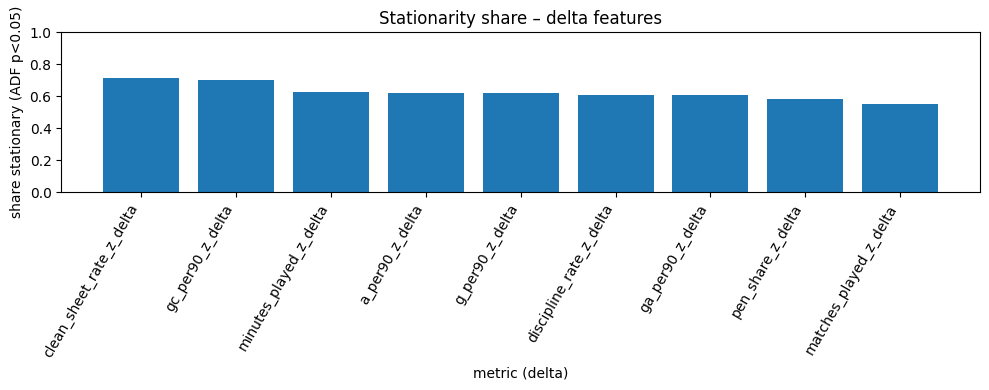

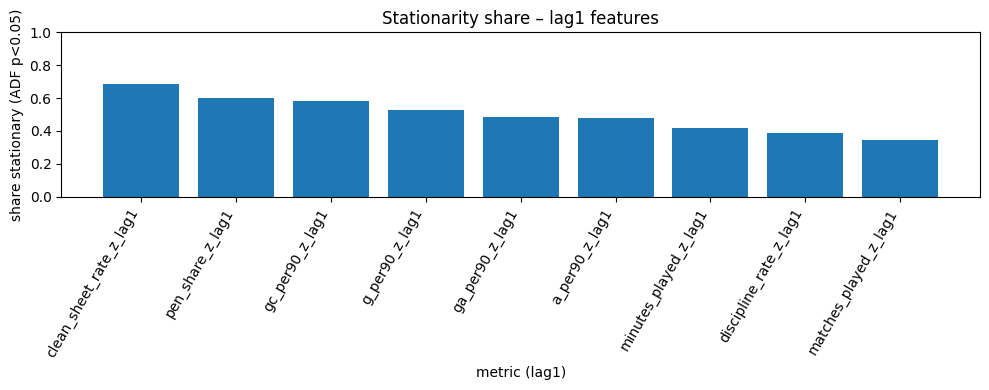

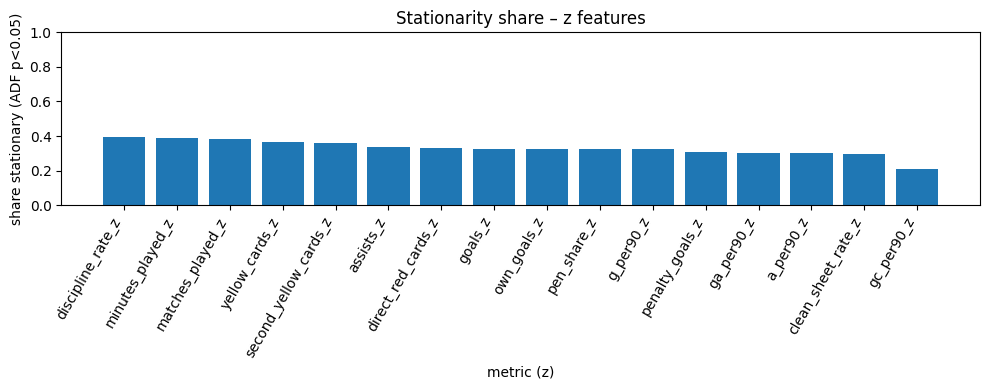

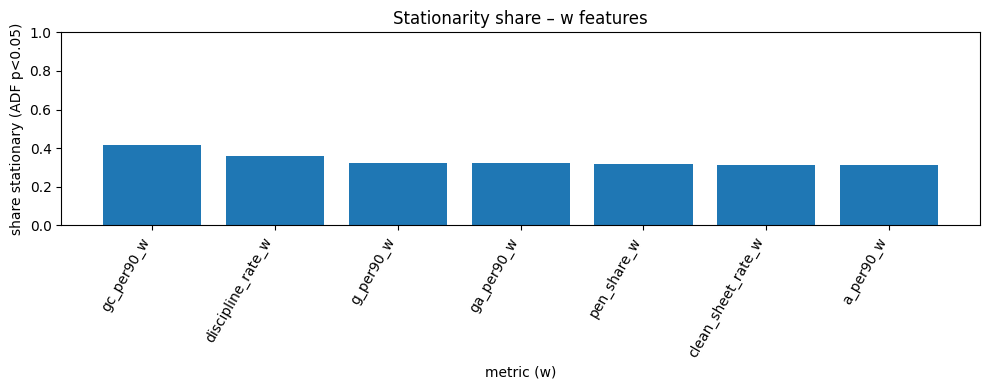

In [14]:
def metric_type(name: str) -> str:
    if "_delta" in name: return "delta"
    if "_lag1" in name:  return "lag1"
    if name.endswith("_w"): return "w"
    return "z"

summary["type"] = summary["metric"].apply(metric_type)

# One figure per type (keeps each plot readable)
for t in ["delta", "lag1", "z", "w"]:
    sub = summary[summary["type"] == t]
    if sub.empty: 
        continue
    plt.figure(figsize=(10, 4))
    plt.bar(sub["metric"], sub["share_stationary"])
    plt.xticks(rotation=60, ha="right")
    plt.ylim(0, 1.0)
    plt.xlabel(f"metric ({t})")
    plt.ylabel("share stationary (ADF p<0.05)")
    plt.title(f"Stationarity share – {t} features")
    plt.tight_layout()
    plt.show()


In [ ]:
summary_display = summary.copy()
summary_display["share_stationary"] = summary_display["share_stationary"].round(3)
summary_display


,metric,n_players_tested,share_stationary,type
0,clean_sheet_rate_z_delta,1070,0.713,delta
1,gc_per90_z_delta,1070,0.701,delta
2,clean_sheet_rate_z_lag1,1070,0.687,lag1
3,minutes_played_z_delta,1070,0.628,delta
4,a_per90_z_delta,1070,0.623,delta
5,g_per90_z_delta,1070,0.618,delta
6,discipline_rate_z_delta,1070,0.608,delta
7,ga_per90_z_delta,1070,0.607,delta
8,pen_share_z_lag1,1070,0.599,lag1
9,pen_share_z_delta,1070,0.586,delta


In [ ]:
df_num = df_feats.select_dtypes(include=[np.number]).drop(
    columns=['player_id', 'team_id'], errors='ignore'
)
# make sure everything is float so pandas can build the covariance matrix
df_num = df_num.astype(float)
# compute covariance matrix
M = df_num.cov()
# eigenvalues and eigenvectors
from numpy import linalg as LA
w, v = LA.eig(M)
w  # eigenvalues

array([ 7.22000172e+05+0.00000000e+00j,  3.71677731e+02+0.00000000e+00j,
        7.79080172e+01+0.00000000e+00j,  5.30984573e+01+0.00000000e+00j,
        3.96895053e+01+0.00000000e+00j,  2.48551894e+01+0.00000000e+00j,
        1.96411858e+01+0.00000000e+00j,  1.41099110e+01+0.00000000e+00j,
        1.18165953e+01+0.00000000e+00j,  5.08414129e+00+0.00000000e+00j,
        4.35385406e+00+0.00000000e+00j,  3.65401402e+00+0.00000000e+00j,
        2.32568638e+00+0.00000000e+00j,  2.15339816e+00+0.00000000e+00j,
        1.98357319e+00+0.00000000e+00j,  1.65473975e+00+0.00000000e+00j,
        1.48259975e+00+0.00000000e+00j,  1.25964023e+00+0.00000000e+00j,
        1.15135431e+00+0.00000000e+00j,  1.11966839e+00+0.00000000e+00j,
        9.70923217e-01+0.00000000e+00j,  9.56179890e-01+0.00000000e+00j,
        9.12602623e-01+0.00000000e+00j,  8.53761280e-01+0.00000000e+00j,
        7.18807720e-01+0.00000000e+00j,  5.24322532e-01+0.00000000e+00j,
        5.03409094e-01+0.00000000e+00j,  4.60167751

In [ ]:
pca = PCA()
pca.fit(df_num)


,n_components,None
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


In [18]:
pca.components_

array([[-3.05052307e-04,  1.25919589e-04, -6.16954191e-05, ...,
         5.20676965e-06,  9.77648608e-06,  3.01396015e-06],
       [ 1.08857143e-01,  7.19452358e-02,  1.07584721e-02, ...,
         9.27928037e-05,  7.29218532e-04,  3.59398384e-04],
       [-1.02050401e-02, -5.03795274e-02,  8.27790553e-04, ...,
         8.43264651e-05, -5.11181927e-05, -1.34806982e-05],
       ...,
       [ 0.00000000e+00, -1.33500544e-11,  1.59071198e-11, ...,
        -2.10925700e-09,  2.74164413e-09, -1.26228927e-09],
       [ 0.00000000e+00,  1.34103818e-11, -2.75365048e-11, ...,
         1.51850207e-09, -1.97408604e-09,  9.10453910e-10],
       [ 0.00000000e+00,  8.49009118e-11, -1.26372736e-10, ...,
         6.64199248e-09, -8.64365321e-09,  3.97157626e-09]],
      shape=(66, 66))

In [19]:
pca.explained_variance_

array([7.22000172e+05, 3.71677731e+02, 7.79080172e+01, 5.30984573e+01,
       3.96895053e+01, 2.48551894e+01, 1.96411857e+01, 1.41099110e+01,
       1.18165953e+01, 5.08414129e+00, 4.35385406e+00, 3.65401402e+00,
       2.32568638e+00, 2.15339816e+00, 1.98357319e+00, 1.65473975e+00,
       1.48259975e+00, 1.25964023e+00, 1.15135431e+00, 1.11966839e+00,
       9.70923217e-01, 9.56179890e-01, 9.12602623e-01, 8.53761280e-01,
       7.18807720e-01, 5.24322532e-01, 5.03409094e-01, 4.60167751e-01,
       4.02749928e-01, 3.58709128e-01, 2.58842906e-01, 2.41066056e-01,
       1.99454529e-01, 1.77034962e-01, 9.90909345e-02, 8.46690087e-02,
       5.49904070e-02, 4.46409003e-02, 3.95605531e-02, 3.24199390e-02,
       2.50537907e-02, 2.38033626e-02, 2.10450748e-02, 1.29434255e-02,
       5.79956334e-03, 4.90078463e-03, 3.22387115e-03, 2.50683405e-03,
       2.27017147e-03, 2.22855766e-03, 1.57494892e-03, 1.20113617e-03,
       6.01039714e-04, 5.33131146e-04, 5.03823658e-13, 2.95632394e-14,
      

In [20]:
pp = pca.transform(df_num)
def biplot(score,coeff,pcax,pcay,labels=None, Labels=None):
    pca1=pcax-1
    pca2=pcay-1
    xs = score[:,pca1]
    ys = score[:,pca2]
    n=score.shape[1]
    scalex = 1/(xs.max()- xs.min())
    scaley = 1/(ys.max()- ys.min())
    plt.scatter(xs*scalex,ys*scaley)
    for i in range(len(xs)): # Iterate through the number of samples
        if Labels is None:
            pass # Placeholder for empty if block
        else:
            plt.text(xs[i]*scalex, ys[i]*scaley, Labels[i], color='blue', ha='center', va='center')
    for i in range(n):
        plt.arrow(0, 0, coeff[i,pca1], coeff[i,pca2],color='r',alpha=0.5)
        if labels is None:
            plt.text(coeff[i,pca1]* 1.15, coeff[i,pca2] * 1.15, "Var"+str(i+1), color='g', ha='center', va='center')
        else:
            plt.text(coeff[i,pca1]* 1.15, coeff[i,pca2] * 1.15, labels[i], color='g', ha='center', va='center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(pcax))
    plt.ylabel("PC{}".format(pcay))
    plt.grid()

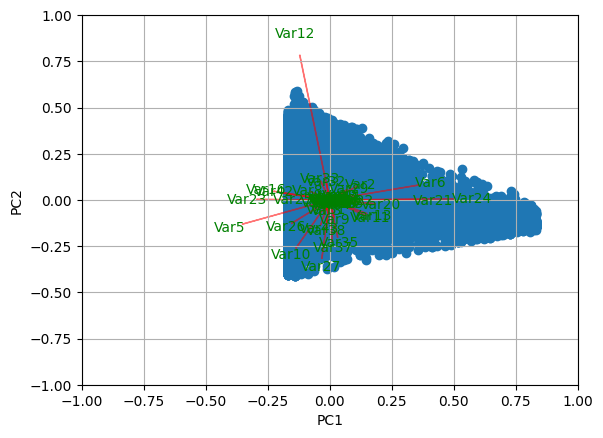

In [21]:
biplot(pp,pca.components_,1,2)
plt.show()

In [22]:
min_max_scaler = preprocessing.MinMaxScaler()
X1 = min_max_scaler.fit_transform(df_num)

In [23]:
pca = PCA()
X_pca=pca.fit(X1)

In [24]:
pca.components_

array([[ 5.96111177e-02,  8.93135656e-02,  1.64351886e-02, ...,
         4.19904194e-03,  1.08866102e-02,  8.21493758e-03],
       [-1.42182583e-01, -1.47997716e-01, -5.38318446e-02, ...,
         1.72979952e-02, -3.71886062e-03, -1.35347334e-02],
       [ 6.23662899e-02,  6.46857937e-02,  3.67914648e-02, ...,
        -1.82324522e-03, -4.11746321e-03,  1.27511414e-02],
       ...,
       [ 0.00000000e+00, -1.06701776e-13,  6.85593243e-14, ...,
         4.83241377e-14,  4.65773253e-15, -1.07192900e-14],
       [-0.00000000e+00,  1.70472587e-14,  2.09160138e-14, ...,
         4.33703976e-14,  3.81790140e-14, -6.70265709e-14],
       [-0.00000000e+00, -5.60350904e-14, -3.32167662e-14, ...,
         1.76767780e-14,  5.36724528e-14,  1.04877045e-13]],
      shape=(66, 66))

In [25]:
pca.explained_variance_

array([4.45084577e-01, 1.10371796e-01, 6.72590214e-02, 5.11309518e-02,
       4.45657821e-02, 2.97309507e-02, 2.72476787e-02, 2.47129544e-02,
       2.19244906e-02, 1.79531963e-02, 1.53406526e-02, 1.46644519e-02,
       1.28600793e-02, 1.27703911e-02, 1.15531310e-02, 8.49541053e-03,
       7.56169882e-03, 7.40454435e-03, 6.86703489e-03, 5.92944842e-03,
       5.66142362e-03, 4.11684692e-03, 3.08776396e-03, 2.03066081e-03,
       1.76739412e-03, 1.62174771e-03, 1.48798286e-03, 1.37807653e-03,
       1.29783138e-03, 1.18827891e-03, 1.04851657e-03, 9.85140776e-04,
       9.69641852e-04, 9.31118246e-04, 7.09982287e-04, 6.76818195e-04,
       5.76403510e-04, 5.45988971e-04, 4.26772864e-04, 3.48517589e-04,
       3.11339886e-04, 2.96391803e-04, 2.75474171e-04, 2.18621277e-04,
       1.71022778e-04, 1.21595486e-04, 1.15073778e-04, 9.83136799e-05,
       8.53415529e-05, 4.68335474e-05, 2.05035736e-05, 1.56460626e-05,
       1.43865807e-05, 5.32359579e-06, 2.65322426e-16, 1.70234909e-16,
      

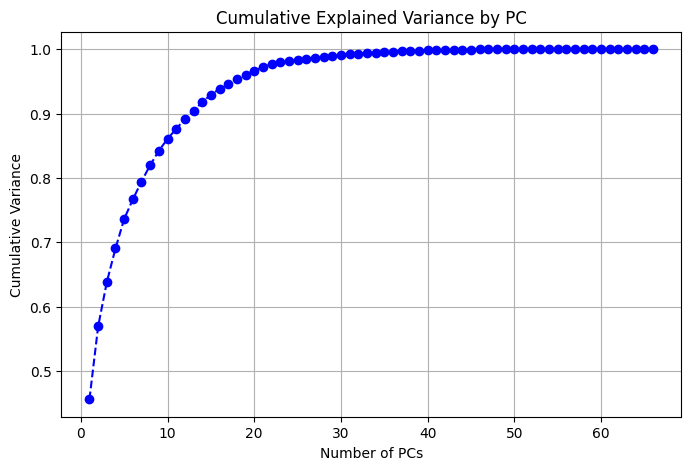

In [26]:
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# --- Visualize Explained variance ---
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance)+1), cumulative_variance, marker='o', linestyle='--', color='b')
plt.title('Cumulative Explained Variance by PC')
plt.xlabel('Number of PCs')
plt.ylabel('Cumulative Variance')
plt.grid(True)
plt.show()


In [27]:
var_exp_df = pd.DataFrame({
    'Component': [f'PC{i+1}' for i in range(len(explained_variance))],
    'Explained Variance': explained_variance,
    'Cumulative Variance': cumulative_variance
})
print(var_exp_df)

   Component  Explained Variance  Cumulative Variance
0        PC1            0.455991             0.455991
1        PC2            0.113076             0.569068
2        PC3            0.068907             0.637975
3        PC4            0.052384             0.690359
4        PC5            0.045658             0.736017
..       ...                 ...                  ...
61      PC62            0.000000             1.000000
62      PC63            0.000000             1.000000
63      PC64            0.000000             1.000000
64      PC65            0.000000             1.000000
65      PC66            0.000000             1.000000

[66 rows x 3 columns]


In [28]:
features = df_num # solo las variables
labels = df_feats["player_id"]  # abreviaturas de los estados

# Escalar los datos
X_scaled = StandardScaler().fit_transform(features)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Obtener vectores de las variables originales
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

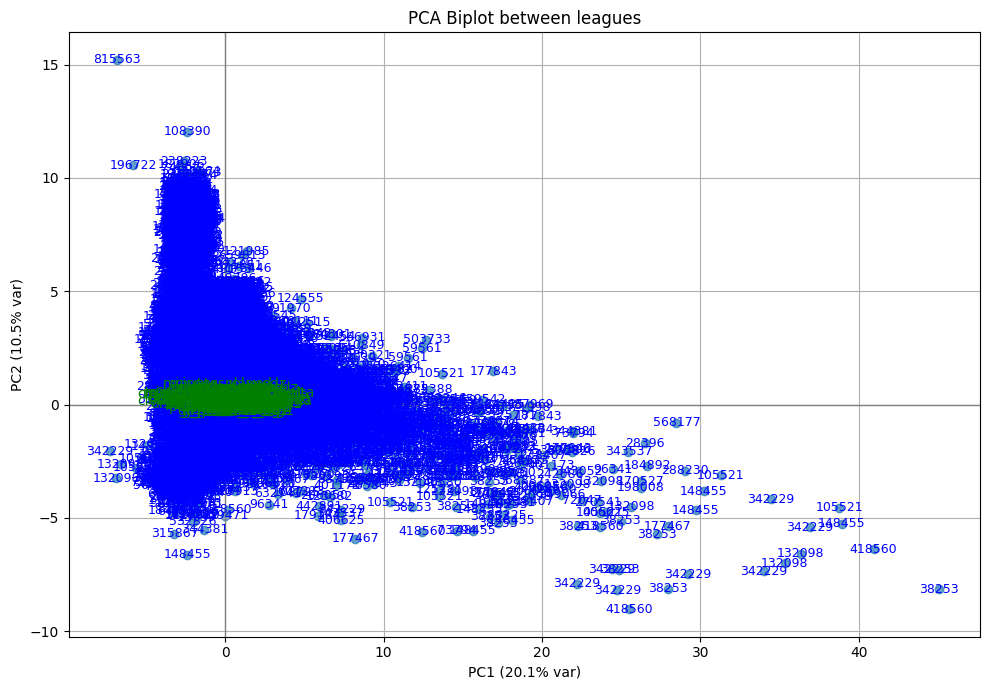

In [29]:
# Crear el biplot
plt.figure(figsize=(10, 7))

# 1. Puntos (proyecciones de los estados)
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7)

# 2. Etiquetas (abreviaturas de los estados)
for i, txt in enumerate(labels):
    plt.text(X_pca[i, 0], X_pca[i, 1], txt, fontsize=9, color='blue', ha='center', va='center')

# 3. Flechas de las variables originales
for i, var in enumerate(features.columns):
    plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], color='brown', alpha=0.7, head_width=0.02)
    plt.text(loadings[i, 0]*1.15, loadings[i, 1]*1.15, var, color='green', ha='center', va='center', fontsize=10)

# 4. Ejes y título
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.title("PCA Biplot between leagues")
plt.grid(True)
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.tight_layout()
plt.show()


 Linear model selection and regularization: LASSO Regression, a shrinkage method


In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(df_num, df_num, test_size=0.3, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Fit Lasso regression model
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

In [ ]:
# Evaluate model performance on test set
y_pred = lasso.predict(X_test)
print(y_pred.mean()) #Mean Square Error over the test set

In [ ]:
# Model Score
print("Model Score: ", lasso.score(X_test, y_test))

In [ ]:
# Lasso Coefficient
lasso.coef_

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

np.random.seed(30) #we fix the seed so we can reproduce the data any time

# Perform grid search with cross-validation
lasso_cv = GridSearchCV(Lasso(), param_grid, cv=5)
lasso_cv.fit(X_train, y_train)

# Print best parameter values and score
print("Best Parameters:", lasso_cv.best_params_)
print("Best Score:", lasso_cv.best_score_)

In [ ]:
#Let's extract the best value of alpha
lasso_cv.best_params_.get('alpha')

In [ ]:
#And re-evaluate the Lasso regression model with this alpha
lasso = Lasso(alpha=lasso_cv.best_params_.get('alpha'))
lasso.fit(X_train, y_train)
# Evaluate model performance on test set
y_pred = lasso.predict(X_test)
print(y_pred.mean()) #Mean Square Error over the test set

In [ ]:
# Model Score
print("Model Score: ", lasso.score(X_test, y_test))

In [ ]:
# Lasso Coefficient
lasso.coef_

factor analysis


In [ ]:
import numpy as np, pandas as pd
from sklearn.preprocessing import StandardScaler

# Keep only numeric cols and drop IDs
X = (df_feats.select_dtypes(include=[np.number])
         .drop(columns=['player_id','team_id'], errors='ignore')
         .replace([np.inf, -np.inf], np.nan)
         .dropna(axis=0))

# Drop constant columns (variance = 0)
X = X.loc[:, X.nunique(dropna=True) > 1]

# Standardize (recommended)
Xz = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns, index=X.index)


In [ ]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

chi2, p = calculate_bartlett_sphericity(Xz)   # want p < 0.05
kmo_per_var, kmo_model = calculate_kmo(Xz)    # >0.6 OK, >0.7 good, >0.8 great
print(f"Bartlett p={p:.3e}, KMO={kmo_model:.3f}")
